In [1]:
from Nowack_Lab.Utilities import multih5
import numpy as np
from os.path import basename
import time

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Current experimental save paths:
D:\data\Orenstein\experiments\2022-06-20_Orenstein-saving-test
Current experiment: 2022-06-20_Orenstein-saving-test-SAMBA-ok
New experiment? y/(n): n


## Measurement and saving

In [2]:
def add_scale(f, name, unit, x):
    path = 'scales/{}'.format(name)
    f[path] = x
    f[path].attrs['unit'] = unit
    return x

In [3]:
from Nowack_Lab.Instruments.keithley import Keithley2450
instruments = {
    'Keithley 2450': Keithley2450(),
}

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


In [4]:
k = instruments['Keithley 2450']
k.output = 'off'
k.source = 'I'
k.Iout_range = 1e-3 #A
k.V_compliance = 21.0 #mV
k.output = 'on'
k.Iout = 0.0e-3 #A

C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


In [12]:
filenames = []
with multih5.Files('test-multih5', 'w',
                   libver = 'latest',
                  ) as fs:
    for f in fs:
        filenames.append(f.filename)
        
        # Metadata
        f.attrs['name'] = 'Test file'
        f.attrs['author/name'] = 'Alex Striff'
        f.attrs['author/email'] = 'abs299@cornell.edu'
        f.attrs['description'] = \
        '''
        A file to test saving sweeps automatically.
        '''
        f.attrs['format'] = \
        '''
        Dataset dimension label <x> is the sweep of scales/<x>.
        Units are given in the 'unit' attribute.
        '''
        
    # Initial instrument states
    for name, instrument in instruments.items():
        for k, v in instrument.__getstate__().items():
            for f in fs:
                f['instruments/{}/{}'.format(name, k)] = v

    # Keithley 2450 needs some time, or else setting current doesn't work
    time.sleep(0.1) #s

    # Sweep scales
    Is, vbs = scales = [
        ('Field coil current', 'A', np.arange(0, 0.3e-3, 1e-6)),
        ('Voltage B', 'V', np.arange(0, 1, 10e-3)),
    ]
    for f in fs:
        for scale in scales:
            add_scale(f, *scale)
    shape = tuple(len(scale[2]) for scale in scales)

    # Sweep variables
    for f in fs:
        x = f.create_dataset('x', shape)
        x.attrs['description'] = 'X value of the fubar'
        x.attrs['unit'] = 'X'
        for i, scale in enumerate(scales):
            x.dims[i].label = basename(scale[0])
            
        f.swmr_mode = True # Now we should only modify data

    for iI, I in enumerate(Is[2]):
        instruments['Keithley 2450'].Iout = I
        for ivb, vb in enumerate(vbs[2]):
            # set vb
            for f in fs:
                f['x'][iI,ivb] = np.random.rand()

D:\data\Orenstein\experiments\2022-06-20_Orenstein-saving-test\2022-06-21_155003_test-multih5.hdf5


C:\ProgramData\Anaconda3\lib\site-packages\pyvisa\resources\messagebased.py:573: FutureWarning: ask is deprecated and will be removed in 1.10, use query instead.
  '1.10, use query instead.', FutureWarning)


## Plotting

In [13]:
import h5py as h5
import matplotlib.pyplot as plt
import matplotlib.cm as cm

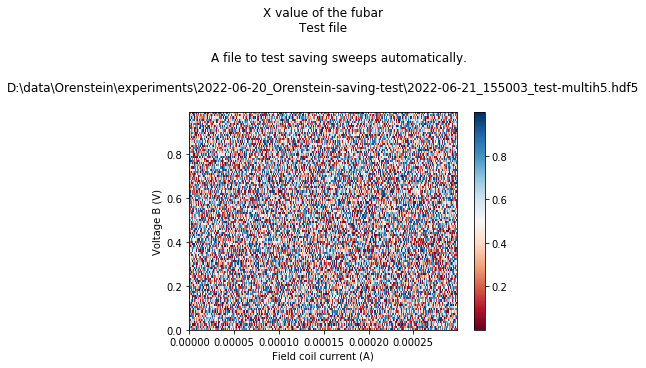

In [14]:
plotfile = filenames[0]
with h5.File(plotfile,
             'r',
             libver = 'latest',
             swmr = True,
            ) as f:
    # Assume 2D data in x
    x = f['x']
    labels = [d.label for d in x.dims]
    scales = [f['scales/{}'.format(l)] for l in labels]
    scaledata = [s[:] for s in scales]
    scaleunits = [s.attrs['unit'] for s in scales]
    scalelabels = ['{} ({})'.format(l, u) for l, u in zip(labels, scaleunits)]
    
    plt.imshow(np.transpose(x),
               extent = (
                   scaledata[-2].min(), scaledata[-2].max(),
                   scaledata[-1].min(), scaledata[-1].max(),
               ),
               cmap = cm.RdBu,
               aspect = 'auto',
              )
    plt.title('\n'.join([
        x.attrs['description'],
        f.attrs['name'],
        f.attrs['description'],
        plotfile,
        '',
    ]))
    plt.xlabel(scalelabels[-2])
    plt.ylabel(scalelabels[-1])
    plt.colorbar()
    plt.show()